# **Amazon Top 50 Bestselling Books 2009 - 2019**

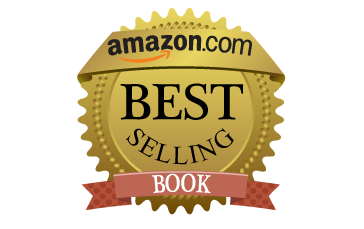

**Dataset on Amazon's Top 50 bestselling books from 2009 to 2019. Contains 550 books, data has been categorized into fiction and non-fiction using Goodreads**

**Our goal in this project is to analyze the data over the different years to answer the following questions:**
* Is there an advantage of one genre over the other in terms of the number of bestselling books, 'User Rating' and 'Reviews' over the 11 years, and are there outliers worth considering?

* Is there a big difference in the average prices for each type of book?

* Do prices affect 'User Rating' and 'Reviews'?

* What is the best 20 author over the 11 years?

* What is the best 20 books over the 11 years?

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import difflib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1.0 Data reading and exploring

In [ ]:
data = pd.read_csv('/kaggle/input/amazon-top-50-bestselling-books-2009-2019/bestsellers with categories.csv')
data.head()

In [ ]:
data.info()

In [ ]:
data.describe(include='all')

# 2.0 Data preparation

**After taking a quick look at the data and making sure that there is no missing data, we will start preparing the data to be ready for analysis.**

In [ ]:
for i in data.loc[:,data.dtypes==object].columns :
    data[i] = data[i].str.title().str.strip()

#### **2.1 similarities**

**There are some sentences and words that are similar to each other and have slight differences in spellings. Let us discover them and correct their errors.**

In [ ]:
diff =[]
for c in ['Name','Author'] :
    for v in data[c].unique():
        for vv in data[c].unique():
            if v != vv and {v,vv} not in diff and len(difflib.get_close_matches(v,[vv],cutoff=0.9))!=0  :
                diff.append({v,vv})
                
diff

In [ ]:
for i in diff :
    i = list(i)
    data = data.replace(i[0],i[1])

#### **2.2 Duplicates**

In [ ]:
for col in data.loc[:,data.dtypes==object].columns :
    print('column {} have {} duplicates'.format(col,len(data[data.duplicated(col)])))

**As we can see, our data contains a set of duplicates, We will focus on the Names** (as it is normal for the Author’s name to appear more than once if the author issued more than one book, and it is also normal for the Genre to be repeated as it is the type of book) , **some analysts have deleted the entire Names duplicates, but from my point of view this will affect the conclusions and analyzes as the data is the best selling books for every year for 11 years and some books have achieved success for several years in a row.** (Therefore it appears in the form of duplicates, similar in names but different in years) **Deleting duplicates will result in a different number of books each year** (some years contain 50 books and some are less) **and this will make it difficult for us to compare and analyze for different years, and it will also affect Ranking of the 20 best selling books over 11 years, which we will reach by the end of our analysis.**

**We will suffice with deleting duplicates that occur for the same book for the same year**

In [ ]:
data = data.drop_duplicates(['Name','Year'],keep='last')

# 3.0 Data Summary

In [ ]:
fig_10 = ff.create_distplot([data['User Rating']],group_labels=[''],bin_size=.1,show_rug=False)
fig_10.update_layout(template='simple_white',autosize=False,width=400,height=350,
                     showlegend=False,
                     margin=dict(l=20, r=20, t=20, b=20))
fig_10.show()

**The histogram shows that most User ratings are concentrated from 4.4 to 4.9**

In [ ]:
genre = data.drop_duplicates('Name').groupby('Genre').size()

data['rate_class'] = data['User Rating'].apply(lambda x : 'User Rating above or equal 4.5' if x >= 4.5 else 'User Rating under 4.5' )
rate_class = pd.pivot_table(data.drop_duplicates('Name'),index='Genre',columns='rate_class',values='User Rating',aggfunc=np.size).stack()

In [ ]:
plt.figure(figsize=(18,9))

cmap = plt.get_cmap("tab20c")

ax2 = plt.pie(rate_class,radius=1+0.1,colors=cmap([2,3,6,7]),
        labels = rate_class.index.get_level_values(1),
        wedgeprops=dict(width=0.6, edgecolor='w'),labeldistance=1.1,
        autopct='%1.1f%%',pctdistance=0.85)

ax1 = plt.pie(genre,radius=0.8,colors= cmap([0,4]),
        labels = genre.index,wedgeprops=dict(width=0.6, edgecolor='w'),labeldistance=0.7,
        autopct='%1.1f%%',pctdistance=0.5)

plt.annotate(str(genre.sum()), xy=(0, 0), xytext=(-.12, -.04),fontsize=25)
plt.show()

**The above graph shows the ratio of fiction and non fiction books, and the ratio of ratings for each type (Fiction and Non Fiction) whether it was higher than or equal to 4.5 or less. Where 349 is the total number of our unique books**

# 4.0 Data Visualization and Analysis

### **4.1 No of Fiction & Non Fiction books**

In [ ]:
year = pd.pivot_table(data,columns='Genre',index='Year',values='User Rating',aggfunc=np.size)
fig = px.line(year)
fig.update_layout(template='simple_white',title=dict(text='No_of_books (Fiction & Non Fiction) every year'))
fig.data[0]['line']['color']='#1f77b4'
fig.data[1]['line']['color']='#ff7f0e'
fig.show()

**In this graph, we made a comparison between the number of books for each genre (Non Fiction, Fiction) each year, it appears the superiority of Non Fiction books over Fiction books . The graph also shows two unusual peaks, the first in 2014, in which the dominance was reversed in favor of Fiction books. And the second in 2015 when the number of Non Fiction books rose abnormally. Let's take a closer look at them**

In [ ]:
data.loc[(data['Year']==2014)&(data['Genre']=='Fiction')]

**In an attempt to understand the reason for the large increase in the number of Fiction books in 2014, we searched on Google, where we found that there were about 12 books out of 28 , Either released in 2014 and turned into films in the same year such as** (Divergent, Gone Girl and If I Stay) ,**or books released before 2014. But it turned into films in 2014 such as** (The Book Thief, The Maze Runner and Frozen) , **which led to an increase in thier demand .**

In [ ]:
data.loc[(data['Year']==2015)&(data['Genre']=='Non Fiction')]

**After examining Non Fiction books in 2015, it became clear that there are a large number of books containing the word 'Coloring'. Let's look at their number.**

In [ ]:
no_of_coloringbooks = len(data[(data['Name'].str.contains(r'Coloring',case=False))&(data['Year']==2015)])
print('The number of Non Fiction books that contains word Coloring in their name in 2015 = ',no_of_coloringbooks)

In [ ]:
plt.figure(figsize=(15,7))
no_2015_NonFiction_books = len(data.loc[(data['Year']==2015)&(data['Genre']=='Non Fiction')])

plt.pie([10,no_2015_NonFiction_books-10],autopct='%1.1f%%',
        labels=['Coloring books','Non coloring books'],wedgeprops=dict(width=0.7,edgecolor='w'),
        textprops=dict(fontsize=12),colors=cmap([7,6]))

plt.annotate(no_2015_NonFiction_books,xy=(0,0),xytext=(-.08,-.04),fontsize=20)
plt.title('2015_NonFiction_books (coloring & Non_coloring)')
plt.show()

**With 9 books containing the word coloring, and by searching on google for the rest of the books, we found another book, which is called Balance (Angie'S Extreme Stress Menders), which represents the same category of books which is called adult coloring books, now we have 10 books out of 33 books that represent 30 % Of the total number of Non Fiction books for that year , By searching more for adult coloring books in 2015, we found that they were apparent and became a trend in that year, according to many articles like :** 

* https://www.mprnews.org/story/2016/02/10/books-how-adult-coloring-books-became-popular
* https://www.publishersweekly.com/pw/by-topic/new-titles/adult-announcements/article/68688-the-coloring-craze-adult-coloring-books-2015.html

**So the number of Non Fiction books increased in an unusual way in that year**

### **4.2 Fiction & Non Fiction books reviews**

In [ ]:
year = pd.pivot_table(data,columns='Genre',index='Year',values='Reviews')
fig = px.line(year)
fig.update_layout(template='simple_white',title=dict(text='avg_of_Reviews (Fiction & Non Fiction) every year'))
fig.data[0]['line']['color']='#1f77b4'
fig.data[1]['line']['color']='#ff7f0e'
fig.show()

**Although the number of Non Fiction books is greater than the number of Fiction books each year (except for 2014), the number of reviews for Fiction books is greater than Non Fiction books as shown in the above chart ,lets have a close look at 2018**

In [ ]:
data.loc[(data['Year']==2018)&(data['Genre']=='Non Fiction')].sort_values('Reviews',ascending=False)

**We tried to find an explanation for the unusually large increase in reviews for Non Fiction books for the year 2018. We found that about 8 books whose reviews represent about 54% of the total reviews for that year among the books is Becoming book by Michelle Obama who alone represented about 15 % Of total reviews**

### **4.3 Fiction & Non Fiction books User Rating**

In [ ]:
year = pd.pivot_table(data,columns='Genre',index='Year',values='User Rating')
fig = px.line(year)
fig.update_layout(template='simple_white',title=dict(text='avg_of_User_Rating (Fiction & Non Fiction) every year'))
fig.data[0]['line']['color']='#1f77b4'
fig.data[1]['line']['color']='#ff7f0e'
fig.show()

**As we can see, Fiction books also outperform Non Fiction books in User Rating , but there was a sudden drop in 2012.
let's take a look at it**

In [ ]:
data.loc[(data['Year']==2012)&(data['Genre']=='Fiction')].sort_values('User Rating')

**By searching in Fiction books for the year 2012, we found that there were two books that got unusually low ratings which affected the average User Rating for this year, namely The Casual Vacancy and Fifty Shades of Gray, which got 3.3 and 3.8 respectively, and by searching for them on google, we find that The Casual book Vacancy by JK Rowling was the first book issued by the author after the harry potter series, which achieved unrivaled success, that led to a great demand for the book, which pushed it to be one of the best-selling books in 2012, but it quickly declined due to its poor reviews and the second is Fifty Shades of Gray, which was inspired by twilight, which also led to an increase in its popularity, but it received low ratings due to its BDSM content and the feminist community’s attack on it.**

### **4.4 Fiction & Non Fiction books Prices**

In [ ]:
fig = ff.create_distplot([data.loc[data['Genre']=='Fiction','Price'],data.loc[data['Genre']=='Non Fiction','Price']],['Fiction','Non Fiction'],show_rug=False,show_hist=False)
fig.update_layout(template='simple_white',title=dict(text='Fiction vs Non Fiction books prices'))

**in this graph, it becomes clear to us that the prices of Non Fiction books are slightly higher than the prices of Fiction books, but whether the price of books may affect the User Rating or Reviews ?**

### **4.5 Data correlation**

In [ ]:
fig = px.scatter(data,x='Price',y='User Rating',color='Genre',color_discrete_map={'Fiction':'#1f77b4','Non Fiction':'#ff7f0e'})
fig.update_layout(template='simple_white')

In [ ]:
fig = px.scatter(data,x='Price',y='Reviews',color='Genre',color_discrete_map={'Fiction':'#1f77b4','Non Fiction':'#ff7f0e'})
fig.update_layout(template='simple_white')

**As we can see from the 2 graphs above, there is no correlation or weak correlation between price and Reviews or User Rating**

In [ ]:
fig = px.scatter(data,x='Reviews',y='User Rating',color='Genre',color_discrete_map={'Fiction':'#1f77b4','Non Fiction':'#ff7f0e'})
fig.update_layout(template='simple_white')

**We also tried to find out if there is a correlation between 'Reviews'and 'User Rating', but as shown there is no correlation or weak correlation**

In [ ]:
dummies = pd.get_dummies(data['Genre'],prefix='Genre')
data = pd.concat([data,dummies],axis=1)
data.head()

In [ ]:
corr = data.corr().abs()
for i in corr.columns :
    corr.loc[i,i] = 0
    
sns.heatmap(corr)

**We tried to find out if there is a correlation between data columns in general, but the same result (there is no correlation or weak correlation)**

# **5.0 The best 20 Authors and Books**
**Finally, after we carefully examined and analyzed the data, it's time to identify the 20 best authors and the 20 best books over the 11 years (2009 to 2019).**

### **5.1 Best 20 Authors**

In [ ]:
b_author = data.drop_duplicates('Name').groupby('Author').agg({'User Rating':'mean','Author':'size','Reviews':'sum'})
b_author.columns = ['User Rating', 'no_books','Reviews']
b_author['total_score'] = ((b_author-b_author.min())/(b_author.max()-b_author.min())).sum(axis=1)
b_author = b_author.sort_values('total_score',ascending=False).head(20).sort_values('total_score')
b_author = b_author[['total_score','User Rating','no_books','Reviews']]

In [ ]:
c = sns.color_palette("rocket",25)[:20]
fig =plt.figure(figsize=(15,7))
for col,i in zip(b_author.columns,range(1,len(b_author.columns)+1)):
    ax = fig.add_subplot(1,len(b_author.columns),i)
    ax.hlines(b_author.index,xmin=b_author[col].min()-b_author[col].std(), xmax=b_author[col],color=c)
    ax.scatter(b_author[col],b_author.index,color=c)
    for key in ax.spines:
        ax.spines[key].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.set_xticks([])
    ax.set_title(col)
    for v,ii in zip(b_author[col],range(len(b_author[col]))):
        xtext=v+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.055
        plt.annotate(round(v,2),xy=(v,ii),xytext=(xtext,ii),fontsize=9)
    if i > 1 :
        ax.set_yticks([])
plt.suptitle('Best 20 Authors',fontsize=15,fontweight="bold")
plt.show()

**Our criteria that we used to rate the top 20 authors are based on their average User Rating, the number of best-selling unique books, and the average number of reviews.We gave each author a total score based on what he/she got in each stander.**

### **5.2 Best 20 Books**

In [ ]:
b_book = data.groupby('Name').agg({'User Rating':'mean','Name':'size','Reviews':'mean'})
b_book.columns = ['User Rating', 'no_years_best_selling','Reviews']
b_book['total_score'] = ((b_book-b_book.min())/(b_book.max()-b_book.min())).sum(axis=1)
b_book = b_book.sort_values('total_score',ascending=False).head(20).sort_values('total_score')
b_book = b_book[['total_score','User Rating','no_years_best_selling','Reviews']]

In [ ]:
fig =plt.figure(figsize=(10,7))
for col,i in zip(b_book.columns,range(1,len(b_book.columns)+1)):
    ax = fig.add_subplot(1,len(b_book.columns),i)
    ax.hlines(b_book.index,xmin=b_book[col].min()-b_book[col].std(), xmax=b_book[col],color=c)
    ax.scatter(b_book[col],b_book.index,color=c)
    for key in ax.spines:
        ax.spines[key].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.set_xticks([])
    ax.set_title(col)
    for v,ii in zip(b_book[col],range(len(b_book[col]))):
        xtext=v+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.055
        plt.annotate(round(v,2),xy=(v,ii),xytext=(xtext,ii),fontsize=9)
    if i > 1 :
        ax.set_yticks([])
plt.suptitle('Best 20 Books',fontsize=15,fontweight="bold")
plt.show()

**Our criteria that we used to rate the top 20 books are based on their average User Rating, How many years it has been best selling, and the average number of reviews.We gave each book a total score based on what it got in each stander.**